In [1]:
import networkx as nx
import re
import os
import numpy as np
from matplotlib import pyplot as plt
import json

In [2]:
def pop_match(lines, pattern, i=0):
    """
    Pop a line if it matches the given pattern (and complain if it doesn't).
    """
    line = lines.pop(i)
    match = re.match(pattern, line)
    assert match, f'"{line}" does not match "{pattern}"'
    return match

In [3]:
def parse_int(x):
    if x == '?':
        return None
    return int(x)


mappings = {
    'sex': {
        1: 'male',
        2: 'female',
        0: 'unknown',
        None: 'unknown',
    },
    'race': {
        1: 'white', 
        2: 'black', 
        3: 'hispanic', 
        4: 'asian', 
        5: 'mixed/other',
        0: 'unknown',
        None: 'unknown',
    }
}


def recode(attributes, exclude=None):
    """
    Recode values and return them.
    """
    exclude = exclude or set()
    return {
        key: mappings[key][value] if key in mappings else value
        for key, value in attributes.items() if key not in exclude
    }


def parse_community(community, parse_attributes=True, parse_edges=True):
    graph = nx.DiGraph()

    if parse_edges:
        filename_edges = f'raw/comm{community}.dat'
        with open(filename_edges) as fp:
            lines = [line.strip().lower() for line in fp.readlines()]
            pop_match(lines, "dl")
            match = pop_match(lines, r'n=(\d+)')
            num_nodes = int(match.group(1))
            pop_match(lines, 'format=edgelist1')
            pop_match(lines, 'data[:;]')
            # The edgelist1 format is such that `i` creates the tie and `j` receives it 
            # (cf. https://toreopsahl.com/tnet/software/one-mode-data-structure/). This is the same
            # as expected by networkx.
            edgelist = [(int(i), int(j), int(float(w))) for (i, j, w) in 
                        map(str.split, lines)]
            graph.add_weighted_edges_from(edgelist)


    if parse_attributes:
        filename_attributes = f'raw/comm{community}_att.dat'
        with open(filename_attributes) as fp:
            lines = [line.strip().lower() for line in fp.readlines()]
            pop_match(lines, 'dl')
            match = pop_match(lines, r'nr=(\d+),\s*nc=(\d+)')
            num_rows = int(match.group(1))
            assert num_rows == num_nodes
            num_cols = int(match.group(2))
            match = pop_match(lines, '^format = (edgelist1|fullmatrix)')
            matrix_format = match.group(1)
            pop_match(lines, 'column labels:')
            # Get the columns.
            columns = []
            for _ in range(num_cols):
                match = pop_match(lines, '"(\w+)"')
                columns.append(match.group(1))

            # Skip until we get to the data.
            while lines.pop(0) != 'data:':
                pass

            # Read the data depending on the format.
            data = {}
            if matrix_format == 'edgelist1':
                for line in lines:
                    if line == '!' or not line:
                        continue
                    vertex, column, value = map(int, line.split())
                    column = columns[column - 1]
                    data.setdefault(vertex, {})[column] = value
            elif matrix_format == 'fullmatrix':
                for vertex, line in enumerate(lines, 1):
                    values = list(map(parse_int, line.split()))
                    assert len(values) == len(columns)
                    data[vertex] = dict(zip(columns, values))
            else:
                raise ValueError
            assert len(data) == num_rows

            # Recode the value to literals.
            data = {key: recode(value) for key, value in data.items()}

            # Add the nodes.
            graph.add_nodes_from(data.items())

    return graph

parse_community(1)


In [4]:
# Parse all the datasets and save them as GraphML.
os.makedirs('data', exist_ok=True)
graphs = []
for i in range(1, 85):
    try:
        # 48 does not have attributes; the file is missing online for some reason.
        # 60 had to be manually modified to include the "data:" and "format = edgelist1" items.
        graph = parse_community(i, parse_attributes=i != 48)
        # Add the attributes for community 48 from a different file.
        if i == 48:
            with open('raw/comm48_att.json') as fp:
                data = json.load(fp)
            data = {node['node']: recode(node, exclude={'node'}) for node in data}
            graph.add_nodes_from(data.items())
                
        nx.write_graphml_xml(graph, f'data/community_{i:02}.xml', named_key_ids=True)
        graphs.append(graph)
    except:
        print(f'failed to parse community {i}')
        raise

0.5714285714285714

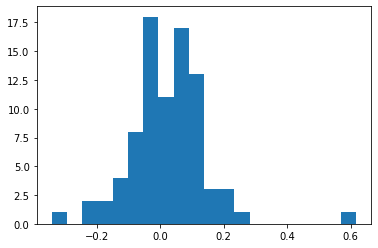

In [ ]:
# Have a look at the correlation between degrees and grades.
corrcoefs = []
for i, graph in enumerate(graphs):
    degrees, grades = np.transpose([(degree, graph.nodes[vertex]['grade']) 
                                    for (vertex, degree) in graph.in_degree
                                    if graph.nodes[vertex].get('grade')])

    # plt.scatter(grades, degrees)
    corrcoefs.append(np.corrcoef(grades, degrees)[0, 1])

plt.hist(corrcoefs, bins=20)
np.mean(np.asarray(corrcoefs) >= 0)